# Notebook for the ENS Challenge Data 2022 - Qube Research & Technologies 

# **Learning factors for stock market returns prediction**

### Data preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

path = '../' 

X_train = pd.read_csv(path+'X_train.csv', index_col=0, sep=',')
X_train.columns.name = 'date'

Y_train = pd.read_csv(path+'Y_train.csv', index_col=0, sep=',')
Y_train.columns.name = 'date'

We have 50 stocks in the dataset and 754 days of returns for each stock.

In [3]:
print(f"X training shape {X_train.shape}, Y training shape: {Y_train.shape}")

X training shape (50, 754), Y training shape: (50, 504)


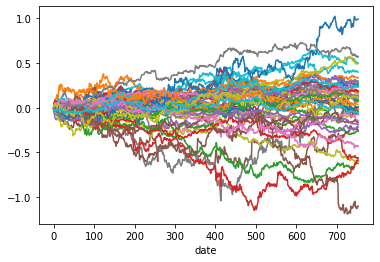

In [4]:
# The cumulative returns of the 50 stocks from the training data set over the three year period 

X_train.T.cumsum().plot(legend=False)
plt.show()

##### A useful data representation:

To speed up upcoming computations, we reshape the data  into a DataFrame with index (date, stock) and columns the lagged return values of the stock at time "date-1, ..., date-250".

In [2]:
X_train_reshape = pd.concat([ X_train.T.shift(i+1).stack(dropna=False) for i in range(250) ], axis=1).dropna()
X_train_reshape.columns = pd.Index(range(1,251), name='timeLag')

In [6]:
X_train_nanincluded = pd.concat([ X_train.T.shift(i+1).stack(dropna=False) for i in range(250) ], axis=1)
X_train_nanincluded.columns = pd.Index(range(1,251), name='timeLag')

<AxesSubplot:xlabel='timeLag', ylabel='date-stocksID'>

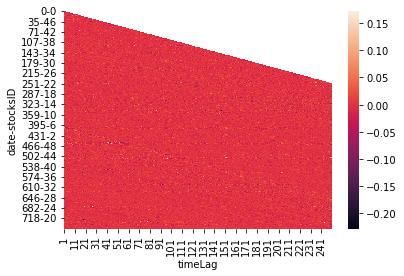

In [7]:
sns.heatmap(X_train_nanincluded)

<AxesSubplot:xlabel='timeLag', ylabel='date-stocksID'>

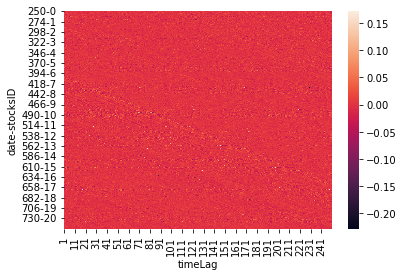

In [8]:
sns.heatmap(X_train_reshape)

The reason why the shape of this new datafram is (25200, 250) is because we have 754 days of returns for each stock and we have 50 stocks. So initially we have 754*50 = 37700 datapoints organised as 754 rows and 50 columns. We then calculate the lagged returns for the past 250 days and stack this data into a single column per day, hence the 250 rows in the final dataframe. We drop any rows with missing values so that is why the lagged returns begin at 250 days. (We can't calculate the lagged returns for the first 250 days because we don't have the returns for the 250 days prior to them!) We end up with $754-250 = 504$ rows of data for each stock, so we have $504*50 = 25200$ rows for each of the 250 lagged return columns. Hence the final dataframe's dimensions are (25200, 250). That's a whole lot of data!

In [9]:
X_train_reshape.shape

(25200, 250)

The motivation is that, given model parameters 'A' and 'beta', the associated predictions for Y_train are simply given by **Ypred = ( X_train_reshape @ A @ beta ).unstack().T**

# The prediction model

## Stiefel matrices

##### Example 1: autoregressive model AR(F)
Here we create an autographic model AR(F) with D=250 and F=10. The matrix only has values of 1 on the diagonal of the first F rows and 0 elsewhere.

In [10]:
def autoRegA(D=250, F=10):
    
    A = np.zeros((D,F))
    for i in range(F):
        A[i,i] = 1
    return A

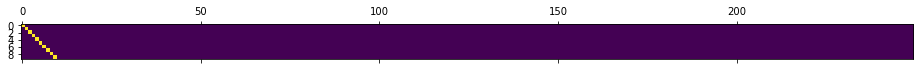

In [11]:
A = autoRegA()
plt.matshow(A.T)
plt.show()

##### Example 2: uniformly random Stiefel matrix A

Here we create a uniformly random Stiefel matrix A with D=250 and F=10. This just populates the matrix with random values between 

In [5]:
def randomA(D=250, F=10):  
    
    M = np.random.randn(D,F)
    randomStiefel = np.linalg.qr(M)[0] # Apply Gram-Schmidt algorithm to the columns of M
    
    return (randomStiefel)

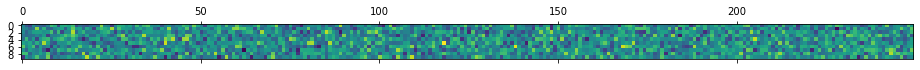

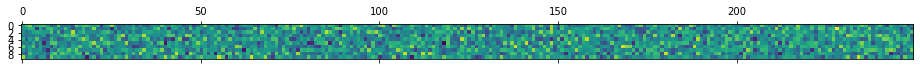

Min: -0.196 , Max: 0.209, Matrix norm: 3.162
Min: -3.358 , Max: 3.165, Matrix norm: 50.11


In [13]:
RandA, M = randomA()
plt.matshow(RandA.T) ## recall that these are the plots of the TRANSPOSE of the matrix A and M!
plt.matshow(M.T)
plt.show()
print(f"Min: {round(RandA.min(),3)} , Max: {round(RandA.max(),3)}, Matrix norm: {round(np.linalg.norm(RandA),3)}")
print(f"Min: {round(M.min(),3)} , Max: {round(M.max(),3)}, Matrix norm: {round(np.linalg.norm(M),3)}")

## Orthogonality checker

In [45]:
# to check the orthonormality constraints as in the metric:
    
def checkOrthonormality(A): 
    
    bool = True
    D, F = A.shape   
    Error = pd.DataFrame(A.T @ A - np.eye(F)).abs()
    
    if any(Error.unstack() > 1e-6):
        bool = False
     
    return bool

In [15]:
checkOrthonormality(A)

True

## Beta parameters

##### Example 1: "keep the $m$ first factor only" 

In [16]:
def firstBeta(m=1, F=10):

    beta = np.zeros(F)
    beta[:m] = 1
    
    return beta

In [17]:
beta = firstBeta()
beta

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

##### Example 2: given a Stiefel matrix A, return the beta with minimal mean square prediction error on the training data set

In [9]:
def fitBeta(A):
    "The @ symbol is the matrix multiplication operator in Python"
    predictors = X_train_reshape @ A # the dataframe of the 10 factors created from A with the (date, stock) in index F_{t,l} = R_{t+1-k} @ A_{k,l}
    targets = Y_train.T.stack()
    beta = np.linalg.inv(predictors.T @ predictors) @ predictors.T @ targets
    
    return beta.to_numpy()

In [19]:
fitBeta(A)

array([ 0.00623611, -0.00510036, -0.02025586, -0.00353405,  0.0088575 ,
        0.00473335,  0.01333769,  0.00205558, -0.00067165,  0.00917629])

## Metric on the training data set

The function **metric_train** below computes the *in sample* version of the metric for parameters 'A' and 'beta', using the accessible data sets 'X_train' and 'Y_train'. 

The true metric of the challenge is defined the same way except that we use the hidden data sets 'X_test' and 'Y_test' instead of 'X_train' and 'Y_train' (recall the latter contain the returns of 50 *other* stocks from the same stock market and on the *same* time period). 

In [8]:
def metric_train(A, beta): 
    
    if not checkOrthonormality(A): ## If we believe our update method is correct, this should never happen, but it may be useful for debugging
        return -1.0    
    
    Ypred = (X_train_reshape @ A @ beta).unstack().T  # investigate which is faster: unstack or pivot and if it's easier to precompute any of this
    Ytrue = Y_train  # doesn't need to be calculated every time
    
    Ytrue = Ytrue.div(np.sqrt((Ytrue**2).sum()), 1)  # This can be precomputed
    Ypred = Ypred.div(np.sqrt((Ypred**2).sum()), 1) # can any of this be improved?

    meanOverlap = (Ytrue * Ypred).sum().mean() # can this be improved?

    return  meanOverlap

# Examples

##### Test 1: The autoregressive model AR(10)
$$
S_{t+1} := \sum_{\ell=1}^{10} \beta_\ell R_{t+1-\ell}
$$
where the $\beta_\ell$'s are fitted by minimizing the mean square prediction error on the training data set. 

In [23]:
A = autoRegA()
beta = fitBeta(A)

metric_train(A, beta) # public metric: 0.01282

0.02402799094688757


##### Test 2: The two factor model using '5-day returns' and 'momentum'
This model is suggested in the description of the challenge and reads
$$
S_{t+1} := \beta_1 \,R_t^{(5)} + \beta_2 \,R_{t-20}^{(230)},\qquad \text{ with }\quad R_t^{(m)}:= \frac1{\sqrt{m}}\sum_{k=1}^{m} R_{t+1-k},
$$
where we find the parameters $\beta_1$ and $\beta_2$ by minimizing the mean square prediction error on the training data set.  

*NB: the construction below actually shows how a model with $F\leq 10$ factors be recasted into the framework of the challenge.*

In [ ]:
def myRandom():
    # Step 1: Create a 250x10 matrix A with the two first columns representing the factors of interest

    A = np.zeros((250,10))
    
    A[0:5, 0] = 1/np.sqrt(5) # 5-day return factor
    A[5:235, 1] = 1/np.sqrt(230) # momentum factor
    A[235:250, 2] = 1/np.sqrt(15) # momentum factor
    A[5:250, 0] = 1/np.sqrt(245) # 245-day return factor
    for i in range(0,250):
        A[i,3] = np.cos(i) + np.random.uniform(0,1) # random factors
        A[i,3] = A[i,3]/np.sqrt((A[i,3]**2).sum()) # normalize the random factors
    for i in range(6,250):
        A[i,0] = np.cos(np.random.uniform(0,1))
        A[i,2] = 1/np.sqrt(np.cos(np.random.uniform(0,1)))
        A[i,4] = np.sin(np.random.uniform(0,1))
        A[i,5] = np.tanh(np.random.uniform(0,1))
        A[i,6] = np.cos(np.random.uniform(0,1)) + np.sin(np.random.uniform(0,1))
        A[i,7] = np.arcsinh(np.random.uniform(0,1))
        A[i,8] = np.cosh(np.random.uniform(0,1))
        A[i,9] = 1 - np.random.uniform(0,1)
        
        
    # A[0:250, 3] = 1/np.cos() # 250-day return factor

    # Step 2: Fill the remaining columns of A with random orthonormal vectors, that are orthogonal to the two first columns
    # plt.matshow(A.T)
    # plt.show
    # orthoProj = np.eye(250) - np.outer(A[:, 0], A[:, 0]) - np.outer(A[:, 1], A[:, 1]) - np.outer(A[:,2], A[:,2]) # projection matrix on the orthogonal to the span of A[:,0] and A[:,1]
    A = np.linalg.qr(A)[0] # Apply Gram-Schmidt algorithm to the columns of A
    # A_remaining_columns = orthoProj @ np.random.randn(250, 7) # sample random vectors in the space orthogonal to the first two columns of A
    # A_remaining_columns = np.linalg.qr(A_remaining_columns)[0] # orthonormalize these vectors with Gram-Schmidt algorithm
    # A[:, 3:] = A_remaining_columns

    # plt.matshow(A.T)
    # plt.show()
    # print(checkOrthonormality(A))
    return A

In [ ]:


# Step 3: Compute the mean square optimal beta_1, beta_2 and then complete the vector beta with zeros
A = myRandom()
predictors = X_train_reshape @ A[:, :]
targets = Y_train.T.stack()
beta = np.linalg.inv(predictors.T @ predictors) @ predictors.T @ targets
print(beta)
print(checkOrthonormality(A))
metric_train(A, beta) # public metric: 0.01787

0   -0.016682
1   -0.009502
2   -0.004277
3    0.002698
4    0.002647
5    0.006588
6   -0.012008
7    0.004321
8    0.009733
9   -0.003572
dtype: float64
True


0.02935573340977141

# The benchmark

This the code for the benchmark provided in the challenge description. 

In [2]:
from old_functions import *
from new_functions import *
Niter = 1000
maxMetric = -1
calculatedMetricsPurerandom = []

np.random.seed(1234)

for iteration in range(Niter):
    
    # Generate a uniform random Stiefel matric A and fit beta with minimal mean square prediction error on the training data set
    
    # A, M = randomA() ## Generate a completely random orthonormal matrix
    A = oldrandomA()
    beta = oldfitBeta(A, X_train_reshape, Y_train)
    
    # compute the metric on the training set and keep the best result   
    Y_prediction_meansum = Y_train.div(np.sqrt((Y_train**2).sum()), 1)
    m = 1/newmetric_train(A, beta, X_train_reshape, Y_prediction_meansum)
    calculatedMetricsPurerandom.append(m)
        
    if m > maxMetric:
        print(iteration, 'metric_train:', m)
        
        maxMetric = m
        A_QRT = A
        beta_QRT = beta  

0 metric_train: 0.023313469330359764
1 metric_train: 0.03319696206337411
3 metric_train: 0.03530204860763571
7 metric_train: 0.03999544914662606
67 metric_train: 0.043593689369261196
138 metric_train: 0.044332621329282895
496 metric_train: 0.04441416345796452
675 metric_train: 0.04578782187329137


In [5]:
import pickle

# obj0, obj1, obj2 are created here...

# Saving the objects:
with open('QRT.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([A_QRT, beta_QRT], f)


(array([  4.,   7.,  29.,  52.,  98., 124., 136., 147., 102., 106.,  78.,
         58.,  32.,  15.,   4.,   4.,   3.,   0.,   0.,   1.]),
 array([0.01851738, 0.0202527 , 0.02198801, 0.02372333, 0.02545865,
        0.02719396, 0.02892928, 0.0306646 , 0.03239992, 0.03413523,
        0.03587055, 0.03760587, 0.03934118, 0.0410765 , 0.04281182,
        0.04454714, 0.04628245, 0.04801777, 0.04975309, 0.05148841,
        0.05322372]),
 <BarContainer object of 20 artists>)

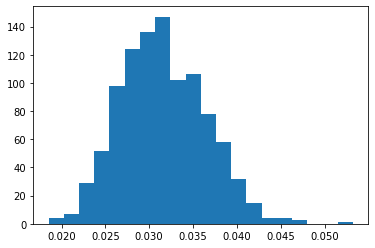

In [ ]:
# x_myRandom = np.array(calculatedMetrics)
# plt.hist(x_myRandom, bins = 20)

(array([  4.,  11.,  18.,  31.,  58., 118., 135., 108., 132., 108.,  91.,
         67.,  48.,  26.,  20.,   9.,   6.,   5.,   3.,   2.]),
 array([0.01876624, 0.02032201, 0.02187778, 0.02343354, 0.02498931,
        0.02654508, 0.02810085, 0.02965662, 0.03121239, 0.03276815,
        0.03432392, 0.03587969, 0.03743546, 0.03899123, 0.04054699,
        0.04210276, 0.04365853, 0.0452143 , 0.04677007, 0.04832583,
        0.0498816 ]),
 <BarContainer object of 20 artists>)

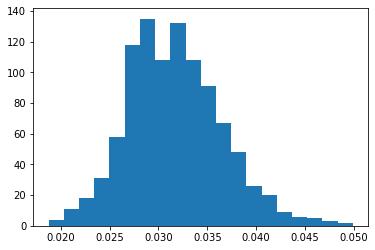

In [ ]:
x_originalRandom = np.array(calculatedMetricsPurerandom)
plt.hist(x_originalRandom, bins = 20)

In [ ]:
metric_train(A_QRT, beta_QRT) # public metric: 0.03535

0.04578782187329136

# Gradients

Attempting to move orthogonal to matrix A to calculate the gradient of metric_train w.r.t. A

The plan of attact to use the following steps:
$$
A = G X_{k}^T - X_{k} G^T
\\
\\
Q = (I + \frac{\alpha}{2} A)^{-1}(I - \frac{\alpha}{2} A)
\\
\\
X_{k+1} = Q X_{k}
$$

A here is not the same as the A in the challenge description. A here is a skew-symmetric matrix used to calculate the Cayley transform Q. X here represents the matrix A in the challenge description. Alpha is the step size from $ X_{k}$ to $X_{k+1}$. $G = \nabla F(X)$ here is the gradient of $F(X)$, the metric_train function, with respect to X.

In [11]:
X = oldrandomA()
if (oldcheckOrthonormality(X)):
    beta = oldfitBeta(X, X_train_reshape, Y_train)
    print("X is orthonormal")
else:
    print("X is not orthonormal")

X is orthonormal


In [12]:
alpha = 0.001 # Set the step size, alpha

In [13]:
oldmetric_train(X, beta, X_train_reshape, Y_train) # public metric: 0.03535

26.435070410918023

Calculate the gradient, $G = \nabla F(X)$, of metric_train w.r.t. A

In [16]:
h = 0.000001 # step size for numerical gradient
grad = np.zeros((250, 10)) # gradient matrix
C = X
for i in range(250):
    print(i)
    for j in range(10):
        C[i, j] += h
        C_beta = oldfitBeta(C, X_train_reshape, Y_train)
        # print(checkOrthonormality(A))
        grad[i, j] = (oldmetric_train(C, C_beta, X_train_reshape, Y_train) - oldmetric_train(X, beta, X_train_reshape, Y_train))/h
        # print(f"grad[{i}, {j}] = {grad[i, j]}")
        C[i, j] -= h

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249


In [119]:
G = grad

Calcuate A
$$
A = G X_{k}^T - X_{k} G^T
$$

In [17]:
A = G@X.T - X@G.T

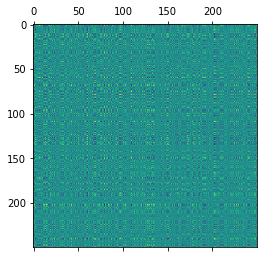

In [18]:
plt.matshow(A)

We know that by construction, A should be skew-symmetric. We can check this by seeing if A.T is close to -A. If it is, then $A.T+A \approx 0$, which means A is skew-symmetric.

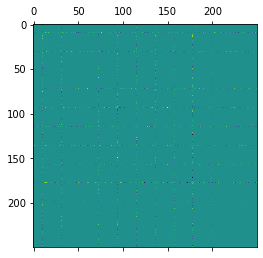

In [19]:
plt.matshow(A.T + A)

We can see that this matrix is close to zero but there are some collumns and rows that are not close to zero. This means that A is almost skew symmetric

Carring on, we will try to apply the rest of the method to see if it works:
$$
Q = (I + \frac{\alpha}{2} A)^{-1}(I - \frac{\alpha}{2} A)
$$


In [20]:
A.shape

(250, 250)

In [21]:
Q = np.linalg.inv((np.eye(250) + alpha/2*A)) @ (np.eye(250) - alpha/2*A)

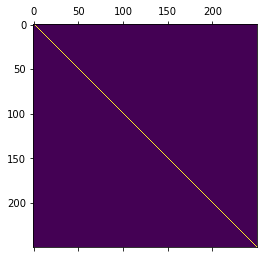

In [22]:
plt.matshow(Q)

In [23]:
X_next = Q@X

In [25]:
oldcheckOrthonormality(X_next)

True

In [26]:
beta_next = oldfitBeta(X_next, X_train_reshape, Y_train)

In [29]:
oldmetric_train(X_next, beta_next, X_train_reshape, Y_train) # public metric: 0.03535

26.326915141540685

In [ ]:
0.0303570453422149

Yahoodey! We have a method of finding another solution to the problem that is also Orthonormal! We can now make some improvements to the code so that we can iterate quickly between these results to try to improve the metric_train value!! This is excellent progress!

Currently, the limiting factor in fast iteration is calculating $G$, the gradient of metric_train. Let's explore how to speed this up.

# Reducing time complexity

Let's start by collecting the project into one place and accuratelt describing each of teh variables and functions. We will then create a create a sequence of these functions in the order that we wish to execute them.
After that, we can perform timing with the time.perf_counter() function to see how long each function takes to execute. We can then use this information to see where we can improve the code.

## Start by generating a Random Stiefel Matrix A.

In [153]:
def randomA(D=250, F=10):  
    
    M = np.random.randn(D,F)
    randomStiefel = np.linalg.qr(M)[0] # Apply Gram-Schmidt algorithm to the columns of M
    
    return (randomStiefel)

## Define the beta fitting function

In [154]:
def fitBeta(A):
    predictors = X_train_reshape @ A
    targets = Y_train.T.stack()
    beta = np.linalg.inv(predictors.T @ predictors) @ predictors.T @ targets
    
    return beta.to_numpy()

In [266]:
A = randomA()
beta = fitBeta(A)
%timeit fitBeta(A)

36.4 ms ± 2.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Define the metric function $F(A)$

In [194]:
def metric_train(A, beta, Ytrain): 
    
    # if not checkOrthonormality(A): ## If we believe our update method is correct, this should never happen, but it may be useful for debugging
    #     return -1.0    
    
    Ypred = (X_train_reshape @ A @ beta).unstack().T  # investigate which is faster: unstack or pivot and if it's easier to precompute any of this
    ## Ytrue = Y_train  # doesn't need to be calculated every time
    
    Ytrain = Ytrain.div(np.sqrt((Ytrain**2).sum()), 1)  # This can be precomputed
    Ypred = Ypred.div(np.sqrt((Ypred**2).sum()), 1) # can any of this be improved?

    meanOverlap = (Ytrain * Ypred).sum().mean() # can this be improved?

    return  1/meanOverlap ## Use the inverse of the mean overlap as the metric since this is a minimisation problem

In [267]:
def metric_train(A, beta): 
    
    if not checkOrthonormality(A):
        return -1.0    
    
    Ypred = (X_train_reshape @ A @ beta).unstack().T         
    Ytrue = Y_train
    
    Ytrue = Ytrue.div(np.sqrt((Ytrue**2).sum()), 1)    
    Ypred = Ypred.div(np.sqrt((Ypred**2).sum()), 1)

    meanOverlap = (Ytrue * Ypred).sum().mean()

    return  meanOverlap  

In [270]:
%timeit metric_train(A, beta)

35.8 ms ± 326 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Calculate the error metric for the current matrix, $A$

In [173]:
A = randomA()
beta = fitBeta(A)
current_metric = metric_train(A, beta)
print(f"Current metric: {round(current_metric, 2)}, equivalent to {round(1/current_metric, 4)} overlap")

Current metric: 47.36, equivalent to 0.0211 overlap
(250, 10)


## Calculate the gradient of the metric function, $G = \nabla F(A)$

Current runtime for the gradient calculation is around 1 second per loop, or 250 seconds for 250 loops. This is not good enough. We need to find a way to speed this up.

In [ ]:
import time
h = 0.000001 # step size for numerical gradient
G = np.zeros((250, 10)) # gradient matrix
C = A # copy of A
start = time.perf_counter()
print(A.shape)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        C[i, j] += h
        C_beta = fitBeta(C)
        # print(checkOrthonormality(A))
        G[i, j] = (metric_train(C, C_beta) - metric_train(A, beta))/h
        # print(f"grad[{i}, {j}] = {grad[i, j]}")
        C[i, j] -= h
end = time.perf_counter()
print(f"Time taken: {round(end-start, 2)} seconds")

In [275]:
## Calculate the gradient of a function given a matrix as the input
def calculateGradient(A, beta, h=0.000001):
    G = np.zeros((A.shape[0], A.shape[1])) # gradient matrix
    C = A # copy of A
    for i in range(A.shape[0]): 
        for j in range(A.shape[1]):
            C[i, j] += h
            C_beta = fitBeta(C)
            G[i, j] = (metric_train(C, C_beta) - metric_train(A, beta))/h # can cache the metric_train(A, beta) value
            C[i, j] -= h
    return G

In [278]:
calculateGradient(A, beta)

array([[-0.00357965, -0.00222184, -0.00343529, ..., -0.00175645,
        -0.00231291, -0.00226018],
       [-0.0016262 , -0.00260729, -0.00148036, ..., -0.0023716 ,
        -0.00227494, -0.00229444],
       [ 0.00142405, -0.0046647 ,  0.00227474, ..., -0.00332635,
        -0.00266002, -0.00278512],
       ...,
       [-0.00443469, -0.00054061, -0.00502102, ..., -0.00149319,
        -0.00186775, -0.00179087],
       [-0.00453639, -0.00033649, -0.00521163, ..., -0.00146189,
        -0.00181353, -0.00173381],
       [-0.00119413, -0.00155812, -0.00159552, ..., -0.00251215,
        -0.00192017, -0.00196128]])

## Calcuate X, the skew-symmetric matrix used to calculate the Cayley transform Q
$$
X = G A_{k}^T - A_{k} G^T
$$

In [176]:
X = G@A.T - A@G.T

## Calculate the Cayley Transform, $Q$
$$
Q = (I + \frac{\alpha}{2} X)^{-1}(I - \frac{\alpha}{2} X)
$$
with step size $\alpha = 0.001$

In [177]:
alpha = 0.001

In [178]:
X.shape

(250, 250)

In [179]:
Q = np.linalg.inv((np.eye(X.shape[0]) + alpha/2*X)) @ (np.eye(X.shape[0]) - alpha/2*X)

## Apply the update rule to $A_{k}$ to get $A_{k+1}$
$A_{k+1} = Q A_{k}$

Grab the error metric from before.

In [183]:
metric_train(A, beta)
print(f"Current metric: {round(current_metric, 2)}, equivalent to {round(1/current_metric, 4)} overlap")

Current metric: 47.36, equivalent to 0.0211 overlap


In [184]:
A_next = Q@A
beta_next = fitBeta(A_next)
new_metric = metric_train(A_next, beta_next)
print(f"Current metric: {round(new_metric, 2)}, equivalent to {round(1/new_metric, 4)} overlap")

Current metric: 28.61, equivalent to 0.035 overlap


We can see that the mean ovelap has been increase from 0.0211 to 0.035 which is a 65% increase.

In [ ]:
A = randomA()
beta = fitBeta(A)
alpha = 0.001
h = 0.000001 # step size for numerical gradient
list_of_metrics = []


In [262]:
def metric_train(A, beta, Ytrain_sum): 
    
    # if not checkOrthonormality(A): ## If we believe our update method is correct, this should never happen, but it may be useful for debugging
    #     return -1.0    
    J = A@beta
    X_J = X_train_reshape @ J
    Ypred = X_J.unstack().T
    # Ypred = (X_train_reshape @ A @ beta).unstack().T
    ## Ytrue = Y_train  # doesn't need to be calculated every time

    # Ytrain = Ytrain.div(np.sqrt((Ytrain**2).sum()), 1)  # This can be precomputed
    Ypred = Ypred.div(np.sqrt((Ypred**2).sum()), 1) # can any of this be improved?
    meanOverlap = (Ytrain_sum * Ypred).sum().mean() # can this be improved?

    return  1/meanOverlap ## Use the inverse of the mean overlap as the metric since this is a minimisation problem

In [ ]:
import time
h = 0.000001 # step size for numerical gradient
G = np.zeros((250, 10)) # gradient matrix
C = A # copy of A
start = time.perf_counter()
Ytrain_sum = Y_train.div(np.sqrt((Y_train**2).sum()), 1)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        C[i, j] += h
        C_beta = fitBeta(C)
        G[i, j] = (metric_train(C, C_beta, Ytrain_sum) - metric_train(A, beta, Ytrain_sum))/h ## metric_train(A, beta) is the same as current_metric! Don't have to call it again
        C[i, j] -= h
end = time.perf_counter()
print(f"Time taken: {round(end-start, 2)} seconds")


# Complete pipeline with old functions

In [1]:
from old_functions import *
from new_functions import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

path = '../' 

X_train = pd.read_csv(path+'X_train.csv', index_col=0, sep=',')
X_train.columns.name = 'date'

Y_train = pd.read_csv(path+'Y_train.csv', index_col=0, sep=',')
Y_train.columns.name = 'date'
X_train_reshape = pd.concat([ X_train.T.shift(i+1).stack(dropna=False) for i in range(250) ], axis=1).dropna()
X_train_reshape.columns = pd.Index(range(1,251), name='timeLag')
# Getting back the objects:
with open('QRT.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    A_QRT, beta_QRT = pickle.load(f)

In [ ]:
metrics = []
A_list = []
beta_list = []
A_list.append(A_QRT)
beta_list.append(beta_QRT)
metrics.append(oldmetric_train(A_list[0], beta_list[0], X_train_reshape, Y_train))
print(f"Current metric: {round(metrics[0], 2)}, equivalent to {round(1/metrics[0], 4)} overlap")
for i in range(0, 9):
    G = oldcalculateGradient(A_list[i], beta_list[i], X_train_reshape, Y_train)
    X = oldSkewSymmetric(G,A_list[i])
    Q = oldCalculateQ(X, 0.01)
    A_list.append(Q@A_list[i])
    beta_list.append(oldfitBeta(A_list[i+1], X_train_reshape, Y_train))
    metrics.append(oldmetric_train(A_list[i+1], beta_list[i+1], X_train_reshape, Y_train))
    print(f"Current metric: {round(metrics[i+1], 2)}, equivalent to {round(1/metrics[i+1], 4)} overlap")

# Time improvements

## Timing fitbeta

The old function looks like this:
    
```python
def oldfitBeta(A, X_train_reshape, Y_train):
    """_fitBeta: Fit the linear factor model to the training data
    
    Args: 
        A (np.array): D x F Stiefel manifold of orthonormal D vectors of length F
        X_train_reshape (np.array): N x D x F array of N training samples of D days of F factors
        Y_train (np.array): N x D array of N training samples of D days of stock returns
        
    Returns:
        beta (np.array): (F,0) vector of model parameters
    """

    predictors = X_train_reshape @ A # the dataframe of the 10 factors created from A with the (date, stock) in index F_{t,l} = R_{t+1-k} @ A_{k,l}
    targets = Y_train.T.stack() ## the dataframe of stock returns that are to be predicted with the 10 factors
    beta = np.linalg.inv(predictors.T @ predictors) @ predictors.T @ targets
    
    return beta.to_numpy()
````

Let's time each individual step of the calculation as they are presented above. To start, we need and A and beta to work with.

In [2]:
A = oldrandomA()
beta = oldfitBeta(A, X_train_reshape, Y_train)

Here is the time of the old function:

In [3]:
%timeit oldfitBeta(A, X_train_reshape, Y_train)

34.7 ms ± 847 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
predictors = X_train_reshape@A
%timeit X_train_reshape@A

21.8 ms ± 1.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
%timeit Y_train.T.stack()

684 µs ± 71 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [22]:
targets = Y_train.T.stack()

In [18]:
%timeit Y_train.T

169 µs ± 4.83 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [19]:
b = Y_train.T
%timeit b.stack()

404 µs ± 6.22 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [23]:
%timeit np.linalg.inv(predictors.T @ predictors) @ predictors.T @ targets

11.7 ms ± 219 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
%timeit predictors.T @ predictors

800 µs ± 54 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [26]:
d = predictors.T @ predictors

In [27]:
%timeit np.linalg.inv(d)

147 µs ± 3.36 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [28]:
e = np.linalg.inv(d)

In [29]:
%timeit e @ predictors.T

4.42 ms ± 81.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [30]:
f = e @ predictors.T

In [31]:
%timeit f @ targets

5.4 ms ± 26.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
%timeit predictors.T @ targets

5.6 ms ± 45 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
g = predictors.T @ targets

In [34]:
%timeit e @ g

17.8 µs ± 908 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [35]:
h = e @ g

In [37]:
%timeit oldfitBeta(A, X_train_reshape, Y_train)

35 ms ± 518 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
%timeit predictors = X_train_reshape @ A
#targets = Y_train.T.stack()
#beta = np.linalg.inv(predictors.T @ predictors) @ predictors.T @ targets

21.8 ms ± 1.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [253]:
%timeit beta = np.linalg.inv(predictors.T @ predictors) @ predictors.T @ targets

11 ms ± 83 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [39]:
from new_functions import *

In [41]:
%timeit newfitBeta(A, X_train_reshape, Y_train)

30.8 ms ± 678 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


As we can see, the fitbeta function has been sped up by around 12%, this should save us around 10 seconds per loop taking the loop time from 256 seconds to 246 seconds. A small 4% improvement but it is a start.

## Timing the metric_train function

The old metric_train function looks like this:


```python
def oldmetric_train(A, beta, X_train_reshape, Y_train): 
    """Calculate the training error of the linear factor model

    Args:
        A (nd.array): D x F Stiefel manifold of orthonormal D vectors of length F
        beta (nd.array): Model parameters
        X_train_reshape (np.array): Training data
        Y_train (np.array): Training targets

    Returns:
        meanOverlap (float): The mean overlap between the predicted targets and the actual targets
    """
    if not oldcheckOrthonormality(A):
        return -1.0    
    
    Ypred = (X_train_reshape @ A @ beta).unstack().T         # Predicted values, unstacked and transposed
    Ytrue = Y_train
    
    Ytrue = Ytrue.div(np.sqrt((Ytrue**2).sum()), 1)    ## Actual returns normalized by the sum of the squares of the returns
    Ypred = Ypred.div(np.sqrt((Ypred**2).sum()), 1)

    meanOverlap = (Ytrue * Ypred).sum().mean()        ## Mean of the dot product of the normalized returns

    return  meanOverlap
```

Let's time each individual step of the calculation as they are presented above. To start, we need and A and beta to work with.

In [4]:
%timeit oldmetric_train(A, beta, X_train_reshape, Y_train)

35.1 ms ± 553 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [47]:
%timeit checkOrthonormality(A)

716 µs ± 47.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [48]:
%timeit (X_train_reshape @ A @ beta).unstack().T


29.3 ms ± 1.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [49]:
%timeit X_train_reshape @ A

22.8 ms ± 958 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [50]:
%timeit A @ beta

2.29 µs ± 72.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [51]:
Abeta = A @ beta
%timeit X_train_reshape @ Abeta

4 ms ± 21 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [53]:
to_unstack = X_train_reshape @ Abeta
%timeit to_unstack.unstack()

4.11 ms ± 707 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [54]:
to_transpose = to_unstack.unstack()
%timeit to_transpose.T

130 µs ± 6.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [55]:
%timeit Ytrue = Y_train

33.2 ns ± 4.98 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [8]:
Ytrue = Y_train

In [60]:
%timeit Ytrue.div(np.sqrt((Ytrue**2).sum()), 1)

1.91 ms ± 161 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [62]:
Y_pred = (X_train_reshape @ A @ beta).unstack().T

In [63]:
%timeit Y_pred.div(np.sqrt((Y_pred**2).sum()), 1)

1.88 ms ± 71.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [74]:
%timeit (Ytrue*Y_pred).sum().mean()

1.85 ms ± 16.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [76]:
def newmetric_train(A, beta, X_train_reshape, Ytrue):
    a = A @ beta
    b = X_train_reshape @ a
    c = b.unstack()
    Y_pred = c.T
    
    Y_pred = Y_pred.div(np.sqrt((Y_pred**2).sum()), 1)
    meanOverlap = (Ytrue*Y_pred).sum().mean()
    return 1/meanOverlap

In [77]:
%timeit newmetric_train(A, beta, X_train_reshape, Ytrue)

14 ms ± 181 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Compared to the 35.8 ms for the old metric_train function, the newmetric_train function takes 14ms, this is a 61% improvement and will save us around 54.5 seconds per loop bringing the loop time down from 245 seconds to 190 seconds. This is an overall improvement of 256 seconds to 190 seconds, a 25% improvement.

## Timing the gradient function

The old gradient caclulating function is defined below:
```python
def oldcalculateGradient(A, beta, X_train_reshape, Y_train, h=0.000001):
    """ Calculate the gradient of the training error of the linear factor model with respect to the orthonormal matrix A

    Args:
        A (np.array): D x F Stiefel manifold of orthonormal D vectors of length F
        beta (nd.array): Model parameters
        X_train_reshape (np.array): Training data
        Y_train (np.array): Training targets
        h (float, optional): Gradient step. Defaults to 0.000001.

    Returns:
        np.array: A.shape[0] X A.shape[0] matrix of the gradient of the training error with respect to A. A.shape[0] = D if following the challenge rules.
    """
    G = np.zeros((A.shape[0], A.shape[1])) # gradient matrix initialisation
    C = A # copy of A to allow for changes to A without affecting the original matrix, A
    for i in range(A.shape[0]): 
        for j in range(A.shape[1]): ## Loop over all elements of A
            C[i, j] += h # increment a single element of A by h
            C_beta = oldfitBeta(C, X_train_reshape, Y_train) # fit the model to the new A
            G[i, j] = (oldmetric_train(C, C_beta, X_train_reshape, Y_train) - oldmetric_train(A, beta, X_train_reshape, Y_train))/h # calculate the gradient of the training error with respect to the element of A
            C[i, j] -= h # reset the element of A to its original value
    return G # return the gradient matrix
```
We will look at each of the individual steps in the function and time them.

In [81]:
%timeit oldcalculateGradient(A, beta, X_train_reshape, Ytrue)

4min 39s ± 6.31 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [82]:
%timeit np.zeros((A.shape[0], A.shape[1]))

1.11 µs ± 45.5 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [83]:
%timeit C = A

25.8 ns ± 1.04 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [6]:
C = A
%timeit C[0,0] += 1

371 ns ± 9.02 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [86]:
%timeit C_beta = oldfitBeta(C, X_train_reshape, Ytrue)

35.5 ms ± 597 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
A = oldrandomA()

In [16]:
beta = oldfitBeta(A, X_train_reshape, Y_train)

In [34]:
%timeit newfitBeta(A, X_train_reshape, Y_train)

31.7 ms ± 1.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
%timeit (oldmetric_train(C, C_beta, X_train_reshape, Y_train)-oldmetric_train(A, beta, X_train_reshape, Y_train))/0.001

40.5 ms ± 7.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
%timeit oldmetric_train(A, beta, X_train_reshape, Y_train)

35.1 ms ± 282 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
from new_functions import *

In [27]:
def newCalculateGradient(A, beta, X_train_reshape, Ytrue, h=0.000001, previousMetric=None):
    G = np.zeros((A.shape[0], A.shape[1])) # gradient matrix initialisation
    C = A # copy of A to allow for changes to A without affecting the original matrix, A
    for i in range(A.shape[0]): 
        for j in range(A.shape[1]): ## Loop over all elements of A
            C[i, j] += h # increment a single element of A by h
            C_beta = newfitBeta(C, X_train_reshape, Y_train) # fit the model to the new A
            G[i, j] = (newmetric_train(C, C_beta, X_train_reshape, Y_train) - previousMetric)/h # calculate the gradient of the training error with respect to the element of A
            C[i, j] -= h # reset the element of A to its original value
    return G # return the gradient matrix

In [31]:
previousMetric=newmetric_train(A, beta, X_train_reshape, Y_train)

In [32]:
%timeit (newmetric_train(C, C_beta, X_train_reshape, Y_train) - previousMetric)/h

13.9 ms ± 147 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


We have managed to reduce the runtime of the gradient function from 290 seconds for 2500 iterations to 117 seconds for 2500 iterations. This is a 2.5x speedup! Over the course of ~500 iterations of the update scheme this will save around 19 hours of computation time!!

## Speeding up all other functions

The high level overview of the method is as follows:
- Initialise metrics list, A list, and beta list.
- Use the current highest performing A and beta and store them, along with their metric in the respective lists.
- Iterate through the update scheme
  - Calculate the gradient of the metric with respect to $A$
  - Calculate the Skew Symmetric Matrix, $X$
  - Calculate the Cayley Transform, $Q$
  - Calculate the next solution, $A_{k+1} = Q A_{k}$
  - Calculate the next beta, $\beta_{k+1} = $ ```newfitBeta```$(A_{k+1})$
  - Calculate the new metric,  $\\ metric_{k+1} = $ ```newmetric_train```$(A_{k+1}, \beta_{k+1})$
  - Save the new $A, \beta$, and $metric$ to the respective lists
  - Repeat until the metric stops improving

```python
metrics = []
A_list = []
beta_list = []
A_list.append(A_QRT)
beta_list.append(beta_QRT)
metrics.append(oldmetric_train(A_list[0], beta_list[0], X_train_reshape, Y_train))
print(f"Current metric: {round(metrics[0], 2)}, equivalent to {round(1/metrics[0], 4)} overlap")
for i in range(0, 9):
    G = oldcalculateGradient(A_list[i], beta_list[i], X_train_reshape, Y_train)
    X = oldSkewSymmetric(G,A_list[i])
    Q = oldCalculateQ(X, 0.1)
    A_list.append(Q@A_list[i])
    beta_list.append(oldfitBeta(A_list[i+1], X_train_reshape, Y_train))
    metrics.append(oldmetric_train(A_list[i+1], beta_list[i+1], X_train_reshape, Y_train))
    print(f"Current metric: {round(metrics[i+1], 2)}, equivalent to {round(1/metrics[i+1], 4)} overlap")
```

In [36]:
G = newCalculateGradient(A, beta, X_train_reshape, Y_train, previousMetric=previousMetric)

In [38]:
%timeit oldSkewSymmetric(G, A)

471 µs ± 39.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [39]:
X = oldSkewSymmetric(G, A)

In [40]:
%timeit oldCalculateQ(X,0.1)

12.2 ms ± 2.02 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [41]:
Q = oldCalculateQ(X,0.1)
%timeit Q@A

175 µs ± 5.78 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


As you can see, the effects of calculating $X$, $Q$, and $A_{k+1}$ are negligible compared to the time taken to calculate the gradient. We will not waste time trying to optimise these functions. Any instances in the rest of the code where old function are used will be replaced with their respective new functions.

# The new, sped up update scheme

In [ ]:
metrics = []
A_list = []
beta_list = []
A_list.append(A_QRT)
beta_list.append(beta_QRT)
metrics.append(oldmetric_train(A_list[0], beta_list[0], X_train_reshape, Y_train))
print(f"Current metric: {round(metrics[0], 2)}, equivalent to {round(1/metrics[0], 4)} overlap")
for i in range(0, 9):
    G = oldcalculateGradient(A_list[i], beta_list[i], X_train_reshape, Y_train)
    X = oldSkewSymmetric(G,A_list[i])
    Q = oldCalculateQ(X, 0.01)
    A_list.append(Q@A_list[i])
    beta_list.append(oldfitBeta(A_list[i+1], X_train_reshape, Y_train))
    metrics.append(oldmetric_train(A_list[i+1], beta_list[i+1], X_train_reshape, Y_train))
    print(f"Current metric: {round(metrics[i+1], 2)}, equivalent to {round(1/metrics[i+1], 4)} overlap")

In [40]:
import time
a=0.1
timestr = time.strftime("%Y%m%d-%H%M%S")
print(f"alpha_{a}_{timestr}.pkl")

alpha_0.1_20220927-171010.pkl


In [47]:
def save_current(A, beta, i):
    timestr = time.strftime("%Y%m%d-%H%M%S")
    with open(f"TuesdayRuns/iteration_{i}_alpha_{a}_{timestr}.pkl", 'wb') as f:
        pickle.dump([A, beta], f)

In [48]:
save_current(A_list[0], beta_list[0], 10)

In [52]:
metrics = []
A_list = []
beta_list = []
Ytrue = Y_train.div(np.sqrt((Y_train**2).sum()), 1)
A_list.append(A_new)
beta_list.append(beta_new)
metrics.append(newmetric_train(A_list[0], beta_list[0], X_train_reshape, Ytrue))
print(f"Current metric: {round(metrics[0], 2)}, equivalent to {round(1/metrics[0], 4)} overlap")
for i in range(0, 500):
    G_new = newCalculateGradient(A_list[i], beta_list[i], X_train_reshape, Y_train, h=0.000001, previousMetric=metrics[i])
    X_new = oldSkewSymmetric(G_new, A_list[i])
    # X_old = oldSkewSymmetric(G_old, A_list[i])
    Q_new = oldCalculateQ(X_new, 0.1)
    # Q_old = oldCalculateQ(X_old, 0.1)
    A_new = Q_new@A_list[i]
    # A_old = Q_old@A_list[i]
    beta_new = newfitBeta(A_new, X_train_reshape, Y_train)
    # beta_old = oldfitBeta(A_old, X_train_reshape, Y_train)
    metric_new = newmetric_train(A_new, beta_new, X_train_reshape, Ytrue)
    # metric_old = newmetric_train(A_old, beta_old, X_train_reshape, Ytrue)
    A_list.append(Q_new@A_list[i])
    beta_list.append(newfitBeta(A_list[i+1], X_train_reshape, Y_train))
    metrics.append(metric_new)
    print(f"Current metric: {round(metrics[i+1], 2)}, equivalent to {round(1/metrics[i+1], 4)} overlap")
    # print(f"New metric: {round(metric_new, 2)}, equivalent to {round(1/metric_new, 4)} overlap")
    # print(f"Old metric: {round(metric_old, 2)}, equivalent to {round(1/metric_old, 4)} overlap")
    save_current(A_list[i+1], beta_list[i+1], i)

Current metric: 8.23, equivalent to 0.1214 overlap
Previous metric: 8.23397932673589
Current metric: 8.23, equivalent to 0.1215 overlap
Previous metric: 8.233187973081572
Current metric: 8.23, equivalent to 0.1215 overlap
Previous metric: 8.232506573774499
Current metric: 8.23, equivalent to 0.1215 overlap
Previous metric: 8.231923521800814
Current metric: 8.23, equivalent to 0.1215 overlap
Previous metric: 8.231428540844727
Current metric: 8.23, equivalent to 0.1215 overlap
Previous metric: 8.231012530553462


KeyboardInterrupt: 

In [56]:
def SolutionMetric(A, beta, X_train_reshape, Ytrue):
    y_true = Ytrue
    y_pred = (X_train_reshape @ A @ beta).unstack().T
    
    y_true = y_true.div(y_true.pow(2.0).sum(1).pow(0.5), 0)
    y_pred = y_pred.div(y_pred.pow(2.0).sum(1).pow(0.5), 0)

    mean_overlap = (y_true * y_pred).sum(1).mean()
    return mean_overlap

In [57]:
SolutionMetric(A_QRT, beta_QRT, X_train_reshape, Ytrue)

0.04923199427290791

In [58]:
SolutionMetric(A_new, beta_new, X_train_reshape, Ytrue)

0.10676751127894833

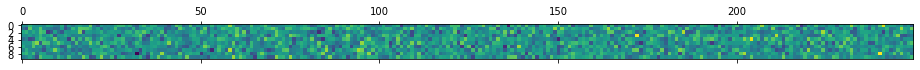

In [55]:
plt.matshow(A_new.T)

In [4]:
beta_new

array([ 0.01065038,  0.08423632,  0.04431822, -0.05385488,  0.00373185,
        0.02009806, -0.01414796, -0.01291783, -0.04397905,  0.03496883])

In [29]:
with open('tenstep_alpha_0.1.pkl', 'wb') as f:
    pickle.dump([A_new, beta_new], f)

In [30]:
with open('tenstep_alpha_0.1.pkl', 'rb') as f:
    A_best, beta_best = pickle.load(f)

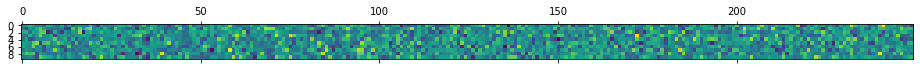

In [6]:
plt.matshow(A_best.T)

In [6]:
metric_train(A_new, beta_new)

0.11862408363899607

In [30]:
A_QRT

array([[-0.00841745, -0.09112678,  0.01725209, ..., -0.03473929,
         0.06321654, -0.06774591],
       [ 0.01242389, -0.09427208,  0.05418738, ...,  0.01282369,
         0.08583064, -0.0288181 ],
       [ 0.08317836,  0.1182797 , -0.02112294, ..., -0.03507859,
         0.02600342,  0.01696892],
       ...,
       [-0.0919992 , -0.04113452,  0.03495228, ...,  0.03692761,
        -0.00319649, -0.01798471],
       [-0.02738563, -0.00105366,  0.00493368, ..., -0.00646085,
         0.02267262,  0.03046375],
       [-0.13498431,  0.08066195,  0.00055814, ..., -0.00286879,
        -0.07284732,  0.08235823]])

In [31]:
beta_QRT

array([ 0.00867739, -0.00034457,  0.03719726,  0.01972286,  0.00199999,
       -0.00577897, -0.01922658, -0.00763269, -0.00466739,  0.00869113])

# Postprocessing

## From $(A, \beta)$ to the output csv format

In [9]:
def parametersTransform(A, beta, D=250, F=10):
    
    if A.shape != (D, F):
        print('A has not the good shape')
        return
    
    if beta.shape[0] != F:
        print('beta has not the good shape')
        return        
    
    output = np.hstack( (np.hstack([A.T, beta.reshape((F, 1))])).T )
    
    return output

In [10]:
# random submission example
np.random.seed(1234)

A = oldrandomA()
beta = np.random.rand(10)

# from output to csv file...
output = parametersTransform(A, beta)
pd.DataFrame(output).to_csv(path + 'submissionExample.csv')

# ... and back
output_fromCsv = pd.read_csv(path + 'submissionExample.csv', index_col=0, sep=',').to_numpy()
A = output_fromCsv[:-10].reshape((250, 10))
beta = output_fromCsv[-10:].reshape((10))

In [59]:
# from output to csv file...
output = parametersTransform(A_new, beta_new)
pd.DataFrame(output).to_csv(path + 'submission27092022_evening.csv')

In [15]:
from custom_metric_QRT_22_6BhdSkn import *

In [16]:
output_fromCsv = pd.read_csv(path + 'submission27092022.csv', index_col=0, sep=',').to_numpy()
A = output_fromCsv[:-10].reshape((250, 10))
beta = output_fromCsv[-10:].reshape((10))

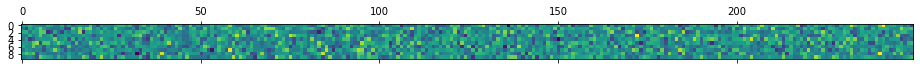

In [17]:
plt.matshow(A.T)

In [22]:
output_fromCsv = pd.read_csv(path + 'submission27092022.csv', index_col=0, sep=',')

In [24]:
x_test = pd.read_csv(path+'X_train.csv', index_col=0, sep=',')
X_train.columns.name = 'date'

In [27]:
df_pred = transform_submission_to_ypred(output_fromCsv, x_test, Y_train)

c:\Users\bensn\Documents\2022\ML\Stocks\Quant challenge\ENS_QRT22_V1\custom_metric_QRT_22_6BhdSkn.py:27: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x_test_reshape = pd.concat([x_test.shift(i+1).stack(dropna=False) for i in range(250)], 1).dropna()


In [28]:
metric(Y_train, df_pred)

0.12054963296521659